#  House Price Estimation- Modern Data, Modern Techniques
---

## Using a Comprehensive Feature-Set

Several models have been built previously with the goal of predicting house prices. However, every one of these models utilizes a <u>different set of variables</u> in order to derive those predictions. *Some of these datasets utilize very few and high-level home characteristics*. In contrast, this housing Dataset presents an oportunity to create a prediction model based on a more comprehensive set of variables. It contains **79 explanatory variables describing (almost) every aspect of residential homes.**

Ask a home buyer to describe their dream house, and they probably won’t begin with the height of the basement ceiling or the proximity to an east-west railroad. But **many similarly unexpected factors play an important role in predicting the price of a house.** This dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. Furthermore, a model built from this extended and up-to-date feature-set could be scaled to predict house prices accross different real-estate markets. There is a clear need for a modernized and expanded version of the often cited Boston Housing dataset. 

## Robust Linear Regression & Tensorflow

With 35+ numeric features and plenty of missing values, dutiful data handling is necessary. High-dimensionality is difficult to visualize, summarize and present with clarity. Some of the most difficult regression techniques involve dealing with non-linearity and understanding assumptions such as homoscedasticity. Lastly, fine-tunning a model with such lengthly pre-processing requires a good strategy. I plan on performing a gridsearch not limited to the algorithm's hyperparameters, but one that optimizes for pre-processing steps as well. This will involve creating a pipeline object and comparing among several data-handling configurations. Ultimately, Robust Regression models will be compared with Deep Learning on Tensorflow.

# Exploratory Data Analysis

In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

train = pd.read_csv('data/train.csv')
sns.set(style='darkgrid')

## Missing Values

There's a lot of missing data here.

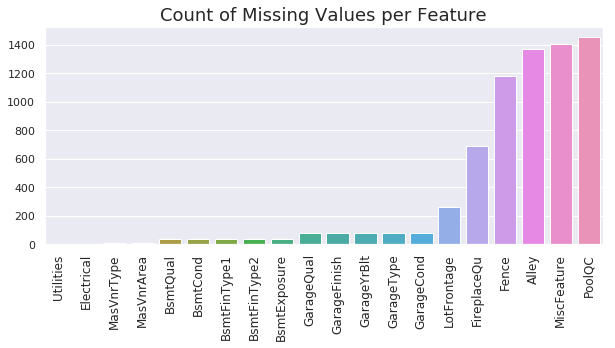

In [29]:
# Make a barplot of missing values per feature
plt.figure(figsize=(10,4))
missing = train.isnull().sum().sort_values()[-20:]
sns.barplot(x=missing.index, y=missing.values)
plt.title('Count of Missing Values per Feature',fontsize=18)
plt.xticks(rotation=90,fontsize=12)
plt.show()

## Normality in Outcome Variable

This is the variable we'll predict.

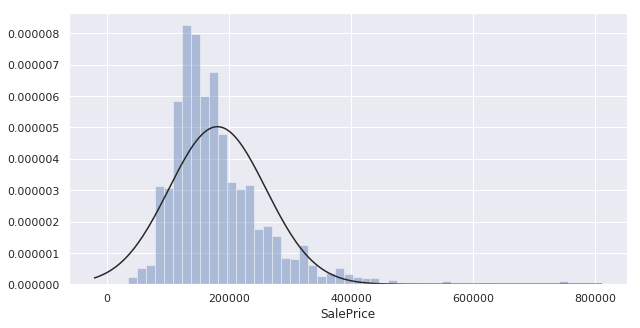

In [52]:
# Checking for normality
plt.figure(figsize=(10,5))
sns.distplot(train['SalePrice'],kde=False,fit=stats.norm)
plt.show()

## Check for the Importance of Categorical Values in Price 

Let's see if certain categories produce changes in price. For each categorical feature, perform an Anova test on the SalePrices of each category. The number of groups for each variable will be the number of unique categories.

In [119]:
# Define numerical and categorical variables
num = [f for f in train.columns if train.dtypes[f] != 'object']
cat = [f for f in train.columns if train.dtypes[f] == 'object']
num.remove('SalePrice'); num.remove('Id')


# Perform Anova OneWay test on each feature's categories

anv = pd.DataFrame()
anv['feature'] = cat
fvals = []
pvals = []

# For each categorical variable...
for var in cat:
    groups = []
    # For each unique value that variable...
    for val in train[var].dropna().unique():
        # Group the prices of that value
        group = train.SalePrice[train[var] == val].values
        groups.append(group)
    # Perform test on n groups    
    f = stats.f_oneway(*groups)[0]
    p = stats.f_oneway(*groups)[1]
    fvals.append(f)
    pvals.append(p)

# Add test results next to each variable
anv['fval'] = fvals
anv['pval'] = pvals
anv.sort_values('fval',inplace=True)

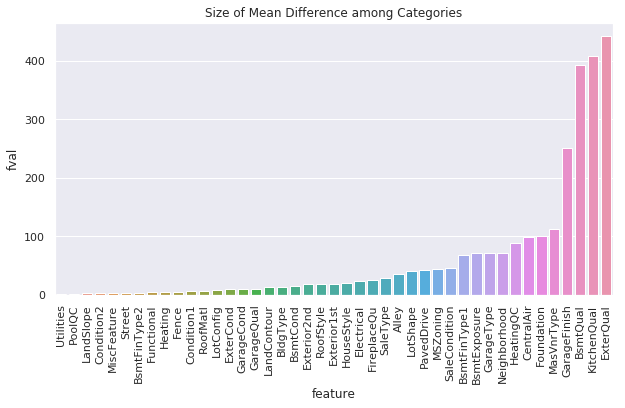

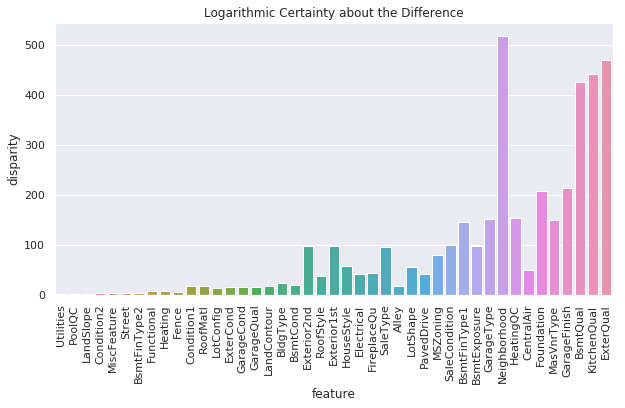

In [126]:
plt.figure(figsize=(10,5))
sns.barplot(data=anv, x='feature', y='fval')
x=plt.xticks(rotation=90)
plt.title('Size of Mean Difference among Categories')
plt.show()

plt.figure(figsize=(10,5))
anv['disparity'] = np.log(1/anv['pval'].values)
sns.barplot(data=anv, x='feature', y='disparity')
x=plt.xticks(rotation=90)
plt.title('Logarithmic Certainty about the Difference')
plt.show()
